# Predict AFK/user based of Date and Time

In [79]:
# imports
import pandas as pd, sklearn as sk, numpy as np, matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks

AFK is an abbreviation for Away From Keyboard.
We are predicting the number of AFK users based on the date and time of the message.

We are hoping to predict if a certain user is AFK or not at a certain pre-defined time frame.

In [80]:
# read data to df
df = pd.read_csv('slack_data.csv')
# list all columns
df.columns

Index(['_id', 'client_msg_id', 'edited.ts', 'edited.user', 'latest_reply',
       'parent_user_id', 'reactions', 'replies', 'reply_count', 'reply_users',
       'reply_users_count', 'root.client_msg_id', 'root.edited.ts',
       'root.edited.user', 'root.latest_reply', 'root.replies',
       'root.reply_count', 'root.reply_users', 'root.reply_users_count',
       'root.subscribed', 'root.team', 'root.text', 'root.thread_ts',
       'root.ts', 'root.type', 'root.user', 'subscribed', 'subtype', 'team',
       'text', 'thread_ts', 'ts', 'type', 'user'],
      dtype='object')

We only need the following columns:
- datetime - to track the time of the message, its a major requirement since we are predicting based on the time of the message
- user - to track the user who sent the message
- text - to track the message or detect afk's

In [81]:
imp_col = ['datetime','user','text']

In [82]:
# convert linux_time to datetime and filter AFK
import datetime
# filter text column
df = df[df['text'].notna()]
# convert linux_time to datetime
ts = lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
df['datetime'] = pd.to_datetime(df['ts'].apply(ts), format='%Y-%m-%d %H:%M:%S')
# filter AFK
t_df = df[imp_col]
t_df = t_df[t_df['text'].str.contains('afk',case=False)]
t_df['text'] = 1
t_df.rename(columns={"text":"text_num"}, inplace=True)
t_df = t_df.sort_values('datetime')
t_df.head()

,datetime,user,text_num
36673,2018-02-01 13:49:44,U026L9E5X,1
17936,2018-02-01 13:49:44,U026L9E5X,1
55010,2018-02-01 13:49:44,U026L9E5X,1
36640,2018-02-01 14:37:34,U0H5WEF6G,1
17903,2018-02-01 14:37:34,U0H5WEF6G,1


## Few exploratory graphs

## Feature Engineering

### Go through the following blogs
- [Analytics Vidhya - 6 Powerful feature Engineering Techniques Time Series](https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/)
- [Towards Data Science - Feature Engineering on Time-Series Data for Human Activity Recognition](https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60)
- [Real-World Machine Learning - 7.3. Time-series features](https://livebook.manning.com/book/real-world-machine-learning/chapter-7/110)
- [Dezyre - 7.3. Time-series features](https://www.dezyre.com/article/8-feature-engineering-techniques-for-machine-learning/423)

### Feature Extraction

In [83]:
''' Logistic Time Series Data (helper methods)
- Filter users if required
- Resample data in 15min time solts or interval for time series
- Convert text to binary
'''

def time_bin_binaryfy(df,time_var):
    df.set_index(df.datetime, inplace=True)
    df = df.resample(time_var).sum()
    return df

def user_filter(df, user=None):
    if user is not None:
        df = df[df['user']==user]
    df.drop(['user'], axis=1, inplace=True)
    return time_bin_binaryfy(df,'1H')

# sample test
temp_df = user_filter(t_df.sample(n=100, random_state=1))
temp_df.head()

,text_num
datetime,
2018-02-13 11:00:00,1
2018-02-13 12:00:00,0
2018-02-13 13:00:00,0
2018-02-13 14:00:00,0
2018-02-13 15:00:00,0


In [84]:
temp_df.max()

text_num    2
dtype: int64

In [85]:
# Date related features
def data_features(df):
    df['year']=df.index.year
    df['month']=df.index.month
    df['day']=df.index.day
    df['dayofweek_num']=df.index.dayofweek
    df['dayofweek_name']=df.index.day_name()
    return df[['year','month','day','dayofweek_num','dayofweek_name']]

# sample test
data_features(temp_df.head(10))

,year,month,day,dayofweek_num,dayofweek_name
datetime,,,,,
2018-02-13 11:00:00,2018,2,13,1,Tuesday
2018-02-13 12:00:00,2018,2,13,1,Tuesday
2018-02-13 13:00:00,2018,2,13,1,Tuesday
2018-02-13 14:00:00,2018,2,13,1,Tuesday
2018-02-13 15:00:00,2018,2,13,1,Tuesday
2018-02-13 16:00:00,2018,2,13,1,Tuesday
2018-02-13 17:00:00,2018,2,13,1,Tuesday
2018-02-13 18:00:00,2018,2,13,1,Tuesday
2018-02-13 19:00:00,2018,2,13,1,Tuesday


In [86]:
# Time related features
def time_features(df):
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    return df[['hour','minute']]

# sample test
time_features(temp_df.head(10))

,hour,minute
datetime,,
2018-02-13 11:00:00,11,0
2018-02-13 12:00:00,12,0
2018-02-13 13:00:00,13,0
2018-02-13 14:00:00,14,0
2018-02-13 15:00:00,15,0
2018-02-13 16:00:00,16,0
2018-02-13 17:00:00,17,0
2018-02-13 18:00:00,18,0
2018-02-13 19:00:00,19,0


### created feature functions
- user_filter
- data_features
- time_features
- lag_features
- rolling_window_features
- expanding_window_features
- basic_statistical_features

In [91]:
prep_data = user_filter(t_df)
prep_data['ds'] = prep_data.index
prep_data['y'] = prep_data['text_num']
prep_data.drop(['text_num'], axis=1, inplace=True)
prep_data.reset_index(drop=True, inplace=True)

from sklearn.model_selection import train_test_split
prep_data_train, prep_data_test = train_test_split(prep_data, test_size=0.2, shuffle=False)

## FB Prophet Model

In [92]:
from prophet import Prophet
m = Prophet()
m.fit(prep_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -66.5899


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       31383.5    0.00320777       249.552      0.4565           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       31384.4   4.18887e-05       180.381   3.469e-07       0.001      211  LS failed, Hessian reset 
     199       31385.2    0.00115382       164.956           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       31385.4   4.31069e-06       77.5303   6.153e-08       0.001      450  LS failed, Hessian reset 
     292       31385.4   1.44973e-06       79.5369      0.5969      0.5969      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [93]:
future_data = pd.DataFrame({'ds': prep_data_test['ds']})
forecast = m.predict(future_data)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2920,2019-10-03 15:00:00,7.952626,3.042978,12.543496
2921,2019-10-03 16:00:00,5.877225,0.919367,10.475865
2922,2019-10-03 17:00:00,4.057636,-0.848827,8.416412
2923,2019-10-03 18:00:00,2.925480,-1.675783,7.437176
2924,2019-10-03 19:00:00,2.296105,-2.252559,6.893760


In [94]:
from sklearn.metrics import mean_squared_error
from math import sqrt
prophet_rmse = sqrt(mean_squared_error(forecast['yhat'], prep_data_test['y']))
print(prophet_rmse)

5.185367571349577


### Prophet plots

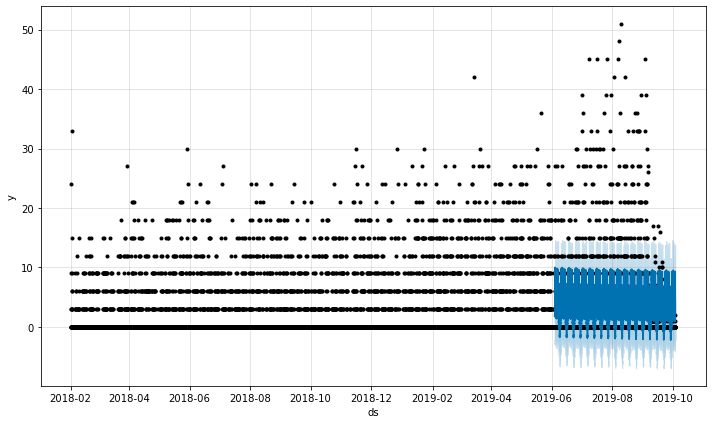

In [95]:
fig1 = m.plot(forecast)

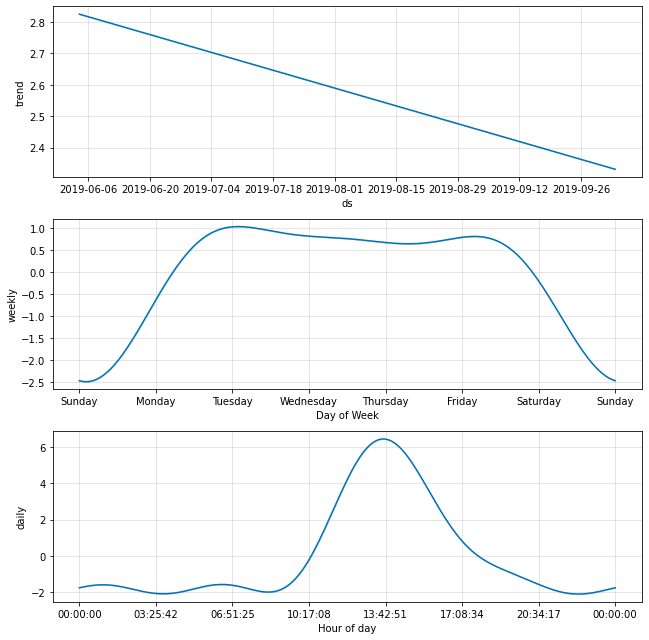

In [96]:
fig2 = m.plot_components(forecast)

### extra regressor

In [97]:
data_features_df = data_features(temp_df.copy())
time_features_df = time_features(temp_df.copy())
lag_features_df = lag_features(temp_df.copy())
rolling_window_features_df = rolling_window_features(temp_df.copy())
expanding_window_features_df = expanding_window_features(temp_df.copy())
# basic_statistical_features_df = basic_statistical_features(temp_df)

In [98]:
temp_df.head()

,text_num
datetime,
2018-02-13 11:00:00,1
2018-02-13 12:00:00,0
2018-02-13 13:00:00,0
2018-02-13 14:00:00,0
2018-02-13 15:00:00,0


In [99]:
# concat all features
features_df = pd.concat([temp_df, data_features_df, time_features_df, lag_features_df, rolling_window_features_df, expanding_window_features_df], axis=1)
features_df.head()

In [103]:
# row count
print(features_df.shape[0])
print(temp_df.shape[0])
print(features_df.columns)

13757
13757
Index(['text_num', 'year', 'month', 'day', 'dayofweek_num', 'dayofweek_name',
       'hour', 'minute', 'lag_0', 'rolling_mean', 'rolling_min', 'rolling_max',
       'expanding_mean', 'expanding_min', 'expanding_max'],
      dtype='object')


## LSTM Model
- https://www.kaggle.com/rohanlimaye20/lstm-dataquest-2020
- https://github.com/AJV009/Machine_Learning_NB/blob/master/Kaggle-DataQuest2020/DQ-EP12.ipynb

In [ ]:
# create a timeseries lstm model to predict the test data

## Exposed Endpoint

### write a blog, example for the blogpost - https://www.qed42.com/insights/future-work/machine-learning/how-we-implemented-machine-learning-slack-detailed-analytics 

User level prediction PLEASE!